Outputs will be saved to images/.
Using the seed 4276357832


  0%|          | 0/20 [00:00<?, ?it/s]

(dreamlikeart:1), A character turnaround of a beautiful female sorceress, fantasy, character sheet


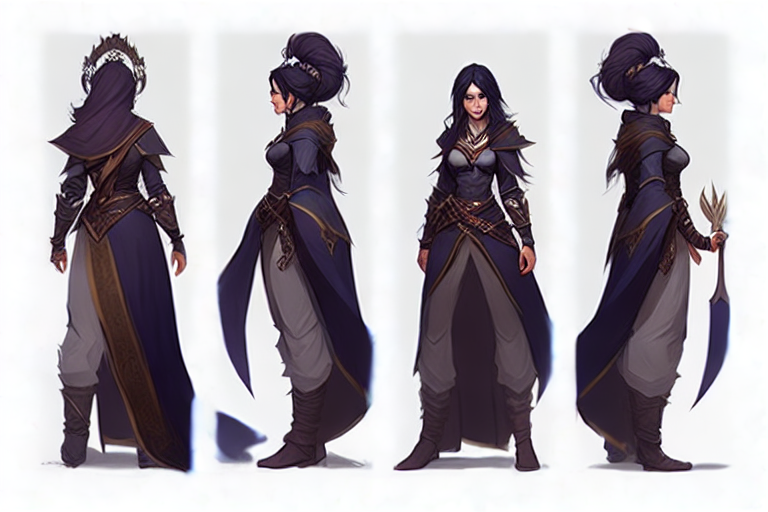

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

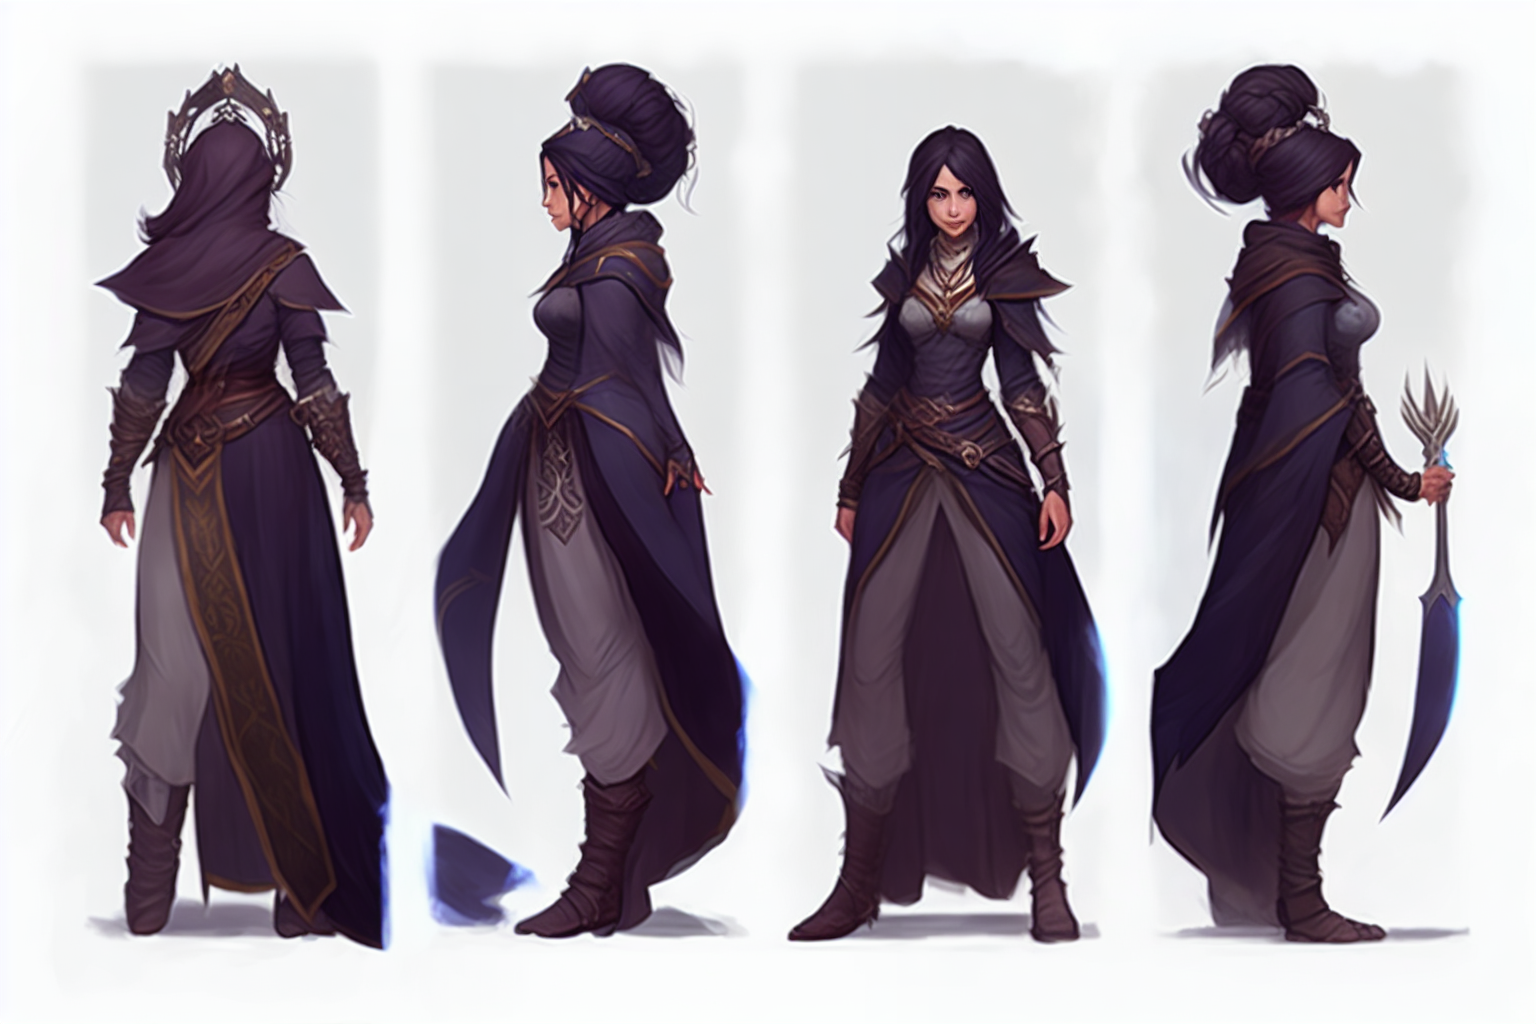

In [20]:
model = "Dreamlike Diffusion" #@param ["Stable Diffusion 1.5", 'Dreamlike Diffusion', 'Openjourney', 'Openjourney V2 Beta', 'seek.art_MEGA', 'Sygil Diffusion', 'Vintedois Diffusion', 'Analog Diffusion', 'Dreamlike Photoreal', 'Anything v3.0', 'Waifu Diffusion 1.3', 'Pastel Waifu Diffusion', 'OpenNiji', 'Untitled', 'Inkpunk Diffusion', 'Vivid Watercolors', 'Van Gogh Diffusion', 'Modern Art Style', 'Corporate Memphis', 'Pokemon Diffusion', 'Robo Diffusion', 'Classic Animation Diffusion', 'Modern Animation Diffusion', 'Ghibli Diffusion', 'Furry Diffusion'] {type:"string"}

prompt = "A character turnaround of a beautiful female sorceress, fantasy, character sheet" #@param {type:"string"}
negative_prompt = "distorted, mutation, dull, kitsch" #@param {type:"string"}
number_of_images = 1 #@param {type:"integer"}
steps = 20 #@param {type:"integer"}
sampler = "UniPC" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)", "UniPC"] 
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
seed = -1 #@param {type:"integer"}   
upscale_results = True #@param {type: "boolean"}
upscale_strength = 0.35 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

add_charturner_embedding = False #@param {type: "boolean"}
add_standard_danbooru_model_quality_prompts = False #@param {type: "boolean"}
add_automatic_keyword = True #@param {type: "boolean"}

######

test_mode = True
enable_attention_slicing = False
enable_xformers = True
enable_gpu_offload = True
should_load_downloaded_embeds = False
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
from IPython.display import display, clear_output

try:
  import torch
  %cd /content/simplest-stable/
  import src
except ImportError as e:
  import os, subprocess
  print("Above error is intentional, don't worry")
  print("Installing libraries...")
  %cd /content/
  subprocess.run(["git", "clone", "https://github.com/cadaeix/simplest-stable.git"])
  %cd /content/simplest-stable/
  if test_mode:
    subprocess.run(["git", "checkout", "test-branch"])
  if enable_xformers:
    subprocess.run(['pip', 'install', 'triton==2.0.0.dev20221202', 'xformers==0.0.16rc424'])
  subprocess.run(["pip3", "install", "-r", "requirements.txt"])
  downloaded_embeds_path = None

# Pillow occasionally has odd import errors
from src.import_patch import patch_import_errors
patch_import_errors()

import os, subprocess, sys, json, logging
import torch
import json
from datetime import datetime
from PIL import Image
from diffusers import ControlNetModel
from src.utils import free_ram, find_custom_models
from src.loading import prepare_pipe, get_model_file_from_civitai_with_model_id, load_embeddings
from src.process import process_and_generate
from src.randomizer import get_default_random_lists_from_folder, get_random_lists_from_folder

logging.disable(sys.maxsize)
clear_output(wait=False)

downloaded_embeds_path = "embeds/"
if not os.path.exists(downloaded_embeds_path):
  subprocess.run(["mkdir", "-p", downloaded_embeds_path])

try:
  outputs_folder
  if not os.path.exists(outputs_folder):
      os.mkdirs(outputs_folder)
  session_folder = outputs_folder
except NameError as e:
  outputs_path = "images/"
  if not os.path.exists(outputs_path):
      os.mkdir(outputs_path)
      
  print(f"Outputs will be saved to {outputs_path}.")
  session_folder = os.path.join(outputs_path, datetime.now().strftime("%Y_%m_%d"))
  if not os.path.exists(session_folder):
      os.mkdir(session_folder)

try:
  model_dict
except NameError as e:
  with open('src/resources/models.json') as modelfile:
      model_dict = json.load(modelfile)
  del modelfile

default_randomizers = get_default_random_lists_from_folder(
    "src/resources/randomizers")
try: 
  custom_randomizer_folder
  if os.path.exists(custom_randomizer_folder):
    randomizers = get_random_lists_from_folder(custom_randomizer_folder)
    randomizers = {**default_randomizers, **randomizers}
  else:
    randomizers = default_randomizers
except NameError as e:
  randomizers = default_randomizers

model_type_mode = "Downloadable Models"
try:
  custom_models_folder
  custom_models_path = custom_models_folder if os.path.exists(custom_models_folder) else None
  custom_model
  use_custom_model
  if use_custom_model and os.path.exists(custom_model):
    model_type_mode = "Custom Models"
    model = custom_model
    custom_model_dict, _ = find_custom_models(custom_models_path)
except NameError as e:
  custom_models_path = None
  model_type_mode = "Downloadable Models"

if add_charturner_embedding:
  charturner_embedding_path = os.path.join(downloaded_embeds_path, "charturner.pt")
  if not os.path.exists(charturner_embedding_path):
    get_model_file_from_civitai_with_model_id("8387", charturner_embedding_path)
  should_load_downloaded_embeds = True
    

pose_sheet = Image.open("src/resources/char_sheet_pose.png").convert('RGB')
width = 768
height = 512
init_image = Image.open("src/resources/char_sheet_base.png").convert('RGB')
mask = Image.open("src/resources/char_sheet_mask.png").convert('RGB')

if add_standard_danbooru_model_quality_prompts:
    prompt = "masterpiece, best quality, " + prompt
    standard_negative = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username"
    negative_prompt = standard_negative if negative_prompt == None or negative_prompt == "" else standard_negative + ", " + negative_prompt

if add_charturner_embedding:
  if "charturner" not in prompt:
    prompt = "(charturner:1), " + prompt

opt = {
    "model_name" : model,
    "eta" : 0.0,
    "steps" : steps,
    "controlnet_image": pose_sheet,
    "init_img" : init_image,
    "mask_image": mask,
    "latent_noise_inpaint": True,
    "number_of_images": number_of_images,
    "prompt" : prompt,
    "negative" : negative_prompt,
    "sampler" : sampler,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : 1,
    "H" : 512,
    "W" : 768,
    #upscale stuff
    "passes" : 1,
    "upscale": upscale_results,
    "upscale_strength" : upscale_strength,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword,
    "prediction_type": model_dict[model]["prediction"],
    "keyword": model_dict[model].get("keyword"),
    "negative_keyword": model_dict[model].get("negative_keyword"),
    "outputs_folder": session_folder,
    "program_version": "Simple Character Sheet Maker (Notebook, pre-release 20230306)"
    }

recreate = False
try:
  controlnet
  pipe
  recreate = model_name != model
  if recreate:
    del pipe
    free_ram()
except NameError as e:
  pipe = None
  controlnet = None
  recreate = True

if recreate:
  try:
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
    pipe, pipe_info = prepare_pipe(
      model_name = model, 
      model_type = model_type_mode, 
      downloadable_model_dict = model_dict,
      custom_model_dict = None,
      cached_model_dict = None,
      enable_attention_slicing = enable_attention_slicing,
      enable_xformers = enable_xformers,
      to_cuda = False)
    if should_load_downloaded_embeds:
      pipe = load_embeddings(downloaded_embeds_path, pipe)
    if enable_gpu_offload:
        pipe.enable_model_cpu_offload()
    else:
        controlnet.to("cuda")
        pipe.to("cuda")
    model_name = opt["model_name"]
  except Exception as e:
    print(f"Failed to load selected model for some reason, please try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, take a screenshot or copy the error below and ask @Cadaeic about it!")
    raise e

opt["controlnet_model"] = controlnet

try:
  pipe, images, images_details = process_and_generate(
    opt = opt,
    pipe = pipe, 
    progress=None,
    randomizer = randomizers,
    display_and_print=True
    )
except Exception as e:
  print(f"Generation of images failed for some reason, try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, take a screenshot or copy the error below and ask @Cadaeic about it!")
  raise e
